In [14]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim, nltk
import string
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### 1) Нормализация

In [15]:
nltk.download('punkt');nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stops = set(stopwords.words('russian')) | {'gt',}
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)


def opt_normalize(texts, top=None):
    uniq = Counter()
    for text in texts:
        uniq.update(text)
    
    norm_uniq = {word:morph.parse(word.replace(':', ''))[0].normal_form for word, _ in uniq.most_common(top)}
    
    norm_texts = []
    for text in texts:
        
        norm_words = [norm_uniq.get(word) for word in text]
        norm_words = [word for word in norm_words if word and word not in stops]
        norm_texts.append(norm_words)
        
    return norm_texts

def tokenize(text):
    words = [word.strip(string.punctuation) for word in text.split()]
    words = [word for word in words if word]
    
    return words

In [0]:
texts = open('habr_texts.txt').read().splitlines()
texts = opt_normalize([tokenize(remove_tags(text.lower())) for text in texts], 30000)

In [0]:
habr_texts = texts

### 2) Нграмы 

In [0]:
ph = gensim.models.Phrases(habr_texts, scoring='npmi', threshold=0.3, 
common_terms=set(stopwords.words('russian')))                                                                      
p = gensim.models.phrases.Phraser(ph)
ngrammed_habr_texts = p[habr_texts]

### 3) Сохранение текстов в vw формате

In [0]:
f = open('habr_texts.vw', 'w')

for i, text in enumerate(texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()

In [0]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()

### 4) Словарь

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',  
                                        data_format='vowpal_wabbit', 
                                        target_folder='batches', 
                                       batch_size=1000)

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', 
                                        data_format='batches')

In [0]:
dictionary = artm.Dictionary()

In [30]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

artm.Dictionary(name=25119770-2474-4a0e-b428-a6fe71bde7a0, num_entries=10885)

In [0]:
dictionary.save_text('dict.txt')

### 5) Модели

In [0]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

In [0]:
model_artm2 = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(300)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.35, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 300)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.25, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 300)])
                                    ]
                        )

In [0]:
model_artm3 = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(150)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.5, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 150)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.5, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 150)])
                                    ]
                        )

In [0]:
model_artm4 = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.15, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.05, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

In [0]:
model_artm.initialize(dictionary=dictionary, )

In [0]:
model_artm2.initialize(dictionary=dictionary, )

In [0]:
model_artm3.initialize(dictionary=dictionary, )

In [0]:
model_artm4.initialize(dictionary=dictionary, )

In [0]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) 
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) 
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) 
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) 

In [0]:
model_artm2.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm2.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) 
model_artm2.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) 
model_artm2.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) 
model_artm2.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) 

In [0]:
model_artm3.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm3.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) 
model_artm3.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) 
model_artm3.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) 
model_artm3.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) 

In [0]:
model_artm4.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm4.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) 
model_artm4.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) 
model_artm4.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) 
model_artm4.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) 

In [0]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

In [0]:
model_artm2.num_document_passes = 2
model_artm2.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

In [0]:
model_artm3.num_document_passes = 2
model_artm3.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

In [0]:
model_artm4.num_document_passes = 2
model_artm4.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

### 6) Хорошие темы модели

Самой хорошей моделью оказался вариант №2. Примеры ее тем:

topic_0: конференция, доклад, презентация, лекция, слайд, выступление, рассказать, мероприятие, андрей, спикер

topic_1: процессор, intel, гб, ноутбук, usb, lenovo, мб, память, ггц, power

topic_2: сеть, лицо, социальный, контакт, отношение, друг, доверие, общество, близкие, отмечать


### 7) График обучения лучшей модели

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 915.773 (ARTM)


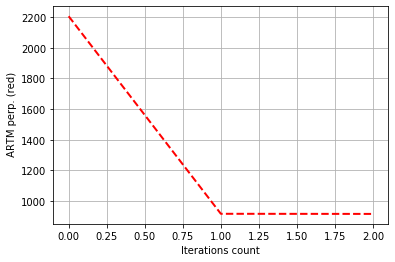

In [45]:
print_measures(model_artm2)

In [0]:
model_artm2.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 300)],
                                                            ))
model_artm2.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 300)]))

In [0]:
model_artm2.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [0]:
phi_tau = model_artm2.regularizers['SparsePhi'].tau
theta_tau = model_artm2.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm2.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm2.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm2.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.972 ARTM)
Sparsity Theta: 0.476 (ARTM)
Kernel contrast: 0.405 (ARTM)
Kernel purity: 0.741 (ARTM)
Perplexity: 336.003 (ARTM)


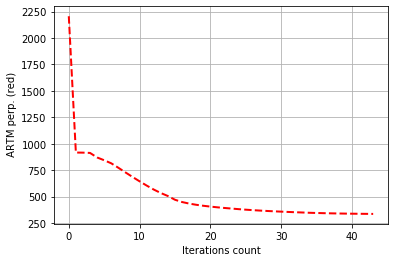

In [90]:
print_measures(model_artm2)

In [94]:
for topic_name in model_artm2.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm2.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
конференция
доклад
презентация
лекция
слайд
выступление
рассказать
мероприятие
андрей
спикер
---------
topic_1: 
процессор
intel
гб
ноутбук
usb
lenovo
мб
память
ггц
power
---------
topic_2: 
сеть
лицо
социальный
контакт
отношение
друг
доверие
общество
близкие
отмечать
---------
topic_3: 
оценка
показатель
оценить
фактор
риска
оценивать
прогноз
методика
эффективность
принятие
---------
topic_4: 
вполне
целое
быстрый
намного
причём
разумеется
возможно
справляться
действительно
столь
---------
topic_5: 
материал
печать
принтер
3d
бумага
сканирование
лист
3d-принтер
форма
печатать
---------
topic_6: 
читать
домашний
слушать
колонка
обсуждать
стоить
звучать
бренд
выпуск
ответ
---------
topic_7: 
заказчик
срок
требование
тз
scrum
product
технический
исполнитель
контракт
сторона
---------
topic_8: 
1
2
up
6
days
3
down
connection
active
closed
---------
topic_9: 
теория
принцип
логический
верный
существовать
сила
утверждение
предположение
хотя
известный
---------
topic_10: 
необходи

### 8) Изменение параметров

В лучшей 2 модели я увеличил количество тем с 200 до 300. Также я увеличил регуляризаторы декорреляции и сглаживания до 0.35 и 0.25. Изначально после 1 прохода вторая модель была несколько хуже, чем 1 или 4 модели, но после добавления регуляризаторов разрежнивания тем (Phi) и разреженности документов (Theta) перплексия значительно уменьшилась и стала лучшей. Всего я проделал 4 итерации в ходе, которых качество каждый раз повышалось, а перплексия уменьшалась.